In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# @Date    : Dec-29-21 15:45
# @Author  : Kan HUANG (kan.huang@connect.ust.hk)

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from datasets.cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from datasets.cs231n.coco_data_loader import COCODataset
from model.rnn_layers_pytorch import CaptioningRNN
from datasets.cs231n.image_utils import image_from_url


# TODO

In [18]:
# 载入 COCO 数据集；返回一个数据集字典。
# 这个笔记本使用降维的特征，
# 也可以改变 pca_features 标志来使用原始的4096维特征。
data_root = os.path.expanduser("~/.datasets/cs231n/coco_captioning")
# 设置 pca_features=True 表示使用降维成512维的图像特征。
data = load_coco_data(base_dir=data_root, pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))


train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## 观察数据 TODO

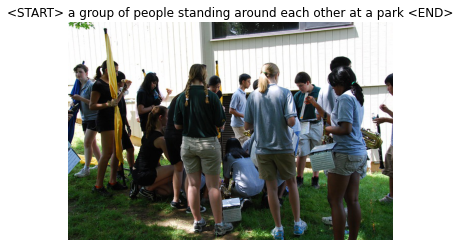

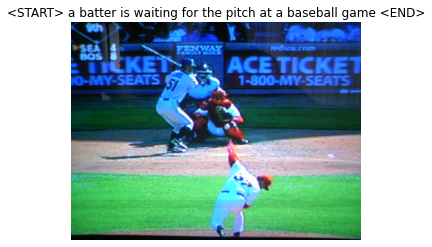

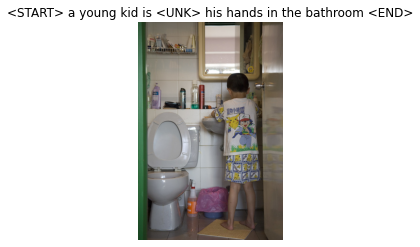

In [6]:
# Sample a minibatch and show the images and captions
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()


# Vanilla RNN: step forward TODO

# Vanilla RNN: forward TODO

# Word embedding: forward TODO

# Temporal Affine layer

# Temporal Softmax loss

# 基于 RNN 的图像描述

RNN for image captioning

# 在小数据集上把模型训练至过拟合

Overfit small data

In [7]:
# Small data
small_data = COCODataset(data_root, batch_size=25, max_train=50, pca_features=True, seed=231)


In [78]:
# Device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Model
N, D, W, H = 32, 20, 30, 40

# Random seed
torch.manual_seed(231)


word_to_idx = data['word_to_idx']
V = len(word_to_idx)
T = 13  # max_length

batch_size = N
input_dim = data['train_features'].shape[1]
timesteps = T
hidden_dim = 512
wordvec_dim = 256
vocab_size = V


small_rnn_model = CaptioningRNN(word_to_idx,
                      input_dim=input_dim,
                      hidden_dim=hidden_dim,
                      wordvec_dim=wordvec_dim,
                                cell_type='rnn').to(device)

# Train the model TODO

In [79]:
def train(epochs, model, train_data, optimizer, scheduler, device, verbose=True, print_every=10):
    """
    Run optimization to train the model.
    """
    assert train_data.split == "train"

    loss_history = []

    num_train = len(train_data)
    iterations_per_epoch = max(num_train // train_data.batch_size, 1)
    num_iterations = epochs * iterations_per_epoch

    for epoch in range(epochs):
        for iter in range(iterations_per_epoch):
            optimizer.zero_grad()

            captions, features, urls = train_data.sample()
            captions, features = torch.from_numpy(captions).long().to(device), torch.from_numpy(features).to(device)

            # Compute loss and gradient
            loss = model(features, captions)
            loss_history.append(loss.item())

            # Perform a parameter update
            loss.backward()
            optimizer.step()

            t = epoch * iterations_per_epoch + iter
            if verbose and t % print_every == 0:
                print('(Iteration %d / %d) loss: %f' % (
                    t + 1, num_iterations, loss_history[-1]))
        scheduler.step()

    return loss_history


(Iteration 1 / 100) loss: 75.367485
(Iteration 11 / 100) loss: 18.323118
(Iteration 21 / 100) loss: 5.468186
(Iteration 31 / 100) loss: 1.920819
(Iteration 41 / 100) loss: 0.644701
(Iteration 51 / 100) loss: 0.362541
(Iteration 61 / 100) loss: 0.209141
(Iteration 71 / 100) loss: 0.197056
(Iteration 81 / 100) loss: 0.151377
(Iteration 91 / 100) loss: 0.155879


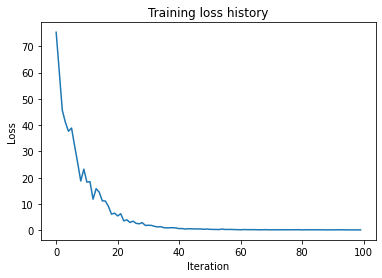

In [80]:
optimizer = torch.optim.Adam(small_rnn_model.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
num_epochs = 50
loss_history = train(num_epochs, small_rnn_model, small_data, optimizer, scheduler,
      device=device, verbose=True, print_every=10)

# Plot the training losses
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()
